1. Name - Humera Bano
2. Github Username - humera811
3. USC ID - 7255691039

In [233]:
# organizing all imports together

import pandas as pd
import os
import glob
import numpy as np
import re
import math
import csv as csv
from os.path import join, getsize
from pathlib import Path
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns


## __Time Series Classification__
Part 1: Feature Creation/Extraction
An interesting task in machine learning is classification of time series. In this problem,
we will classify the activities of humans based on time series obtained by a Wireless
Sensor Network.

#### __(a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/ Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\ %29 . The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity.1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.__

In [234]:
# removing extra comma in cycling dataset9.csv and cycling dataset14.csv manually as suggested on piazza
# bending2 dataset4.csv space separated (delimitter/sep_)
# https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/
path = "../../data/AReM/"
actv_dir = ['bending1', 'bending2']
actv_dir2 = ['bending1','bending2','cycling', 'lying', 'sitting', 'standing', 'walking']
features = ['mean_', 'std_', 'min_', 'first_quartile_', 'median_', 'third_quartile_','max_']
columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']


#### __(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.__

In [235]:
# https://stackoverflow.com/questions/22809061/read-space-separated-data-with-pandas
# https://www.summet.com/dmsi/html/CSVdataFiles.html
# https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.DataFrame.T.html
# https://docs.python.org/3/library/os.html
# https://www.tutorialspoint.com/python/os_walk.htm
# https://www.geeksforgeeks.org/python-os-path-splitext-method/

# !/usr/bin/python
def train_or_test(root):
    trainset = []
    testset = []
    # scanning bottom-to-up
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            # Split the path in root and ext pair
            root_ext = os.path.splitext(name)   
            root_val = root_ext[1]
            if (root_val.endswith('.csv')):
                # https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/
                file_path = os.path.join(root, name)
                # print(file_path)
                my_path = os.path.split(root)
                feature_act = my_path[-1] #to get just the activity name
                # my_path = Path(path)
                # activity = my_path.stem
                regex = '\d+'
                match = re.findall(regex, name)
                # for bending 1 and 2 and dataset 1,2 and 3
                match_activity = int(match[0])
                bool1 = match_activity <= 2
                bool2 = match_activity == 3 and feature_act not in actv_dir
                if (bool1 or bool2):
                    testset.append(file_path)
                else:
                    trainset.append(file_path)
    return trainset, testset
train_set, test_set = train_or_test(path)

### __(c) Feature Extraction Classification of time series usually needs extracting features from them.In this problem, we focus on time-domain features__


#### __i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc)__

Time-domain features are usually used in time series classification are:
1. Means
2. Standard Deviations
3. Skewness, Kurtosis
4. Maximum and minimum values

#### __ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance.You are free to normalize/standardize features or use them directly__

In [236]:
# https://stackoverflow.com/questions/18366797/pandas-read-csv-how-to-skip-comment-lines
# https://stackoverflow.com/questions/25440008/python-pandas-flatten-a-dataframe-to-a-list

csv_files = glob.glob('../../data/AReM/*/*.csv', recursive=True)
# print(csv_files)
sniffer = csv.Sniffer()

def load_data(csv_files, activity, columns, standardize=False):
    column_names = [ft + str(i) for i in range(1, 7) for ft in features]
    train_test_instances  = [] 
    train_test_labels = []
    split=1
    for csv in csv_files:
        root = os.path.dirname(csv)
        my_path = os.path.split(root)
        feature_act = my_path[-1]
        # print(feature_act)
        train_test_labels.append(feature_act)
        #separator
        # https://stackoverflow.com/questions/45732459/retrieve-delimiter-infered-by-read-csv-in-pandas
        sep_ = sniffer.sniff(open(csv).read())
        sep = sep_.delimiter
        if sep == ' ':
            df = pd.read_csv(csv, comment = '#', header=None, sep="\s+")
        else:
            df = pd.read_csv(csv, comment = '#', header=None)
            
        df.columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
        # finding length of each split
        split_length = int(df.shape[0])
        train_test_seg = []
        for j in range(split):
            df_describe = df[j*split_length : min((j+1)*split_length,df.shape[0])]
            df_describe = df_describe.describe().drop('count').drop(columns="# Columns: time").T
            train_test_seg.append(df_describe.to_numpy().flatten())
        train_test_instances.append(np.concatenate(train_test_seg, axis=0))      
    df_new = pd.DataFrame(train_test_instances, columns=column_names)
    # Set for an entire column
    df_new = df_new.loc[:, activity]
    df_new['label'] = pd.Series(train_test_labels) # adding label as suggested on piazza
    return df_new


In [237]:
new_columns = ['min_','max_','mean_','median_','std_','first_quartile_', 'third_quartile_']
activity = [stat + str(i) for i in range(1, 7) for stat in new_columns]
#trainset
train_stats = load_data(train_set, activity, columns)
# train_data.insert(loc=0, column='row_num', value=np.arange(len(train_stats)))
# train_stats.isnull().any()
train_stats


,min_1,max_1,mean_1,median_1,std_1,first_quartile_1,third_quartile_1,min_2,max_2,mean_2,...,first_quartile_5,third_quartile_5,min_6,max_6,mean_6,median_6,std_6,first_quartile_6,third_quartile_6,label
0,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.8300,bending1
1,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700,bending1
2,33.00,47.75,42.179812,43.50,3.670666,39.1500,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000,bending1
3,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000,bending1
4,35.00,47.40,43.954500,44.33,1.558835,43.0000,45.00,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.9400,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600,cycling
65,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000,cycling
66,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,2.736021,...,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175,cycling
67,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300,cycling


In [238]:
test_stats = load_data(test_set, activity, columns)
# test_stats.isnull().any()
test_stats


,min_1,max_1,mean_1,median_1,std_1,first_quartile_1,third_quartile_1,min_2,max_2,mean_2,...,first_quartile_5,third_quartile_5,min_6,max_6,mean_6,median_6,std_6,first_quartile_6,third_quartile_6,label
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372437,...,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending1
2,19.33,43.50,34.227771,35.500,4.889576,30.5000,37.7500,0.0,14.50,3.995729,...,14.7500,18.6700,0.0,9.74,3.394125,3.100,1.792090,2.1050,4.425,walking
3,12.50,45.00,33.509729,34.125,4.850923,30.5000,36.7500,0.0,13.05,4.450771,...,14.6275,18.7500,0.0,8.96,3.378479,3.085,1.787360,2.0600,4.440,walking
4,15.00,46.75,34.660583,35.000,5.315110,31.0000,38.2500,0.0,13.44,4.200896,...,14.2500,18.5000,0.0,8.99,3.244396,3.000,1.630983,2.1200,4.240,walking
5,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending2
6,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending2
7,33.33,48.00,44.334729,45.000,2.476940,42.2500,46.5000,0.0,3.90,0.432958,...,9.3300,17.7500,0.0,5.02,0.933000,0.830,0.673609,0.4700,1.250,standing
8,35.50,46.25,43.174938,43.670,1.989052,42.5000,44.5000,0.0,2.12,0.506583,...,12.7500,16.5000,0.0,5.72,0.911979,0.830,0.666161,0.4700,1.220,standing
9,32.75,47.00,42.760562,44.500,3.398919,41.3300,45.3725,0.0,3.34,0.486167,...,13.0000,18.5650,0.0,5.73,0.842271,0.710,0.722165,0.4300,1.090,standing


### __1. (c). iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.__

In [239]:
data_set = train_stats.append(train_stats, ignore_index=True)
data_set.describe().loc['std']

min_1               8.762140
max_1               4.412987
mean_1              4.899736
median_1            4.937990
std_1               1.752199
first_quartile_1    5.710307
third_quartile_1    4.766155
min_2               0.000000
max_2               5.129019
mean_2              1.594808
median_2            1.431649
std_2               0.899469
first_quartile_2    0.948719
third_quartile_2    2.150367
min_3               3.042703
max_3               4.742450
mean_3              3.849179
median_3            3.831669
std_3               0.992367
first_quartile_3    4.130098
third_quartile_3    3.931595
min_4               0.000000
max_4               2.293990
mean_4              1.175467
median_4            1.145382
std_4               0.471793
first_quartile_4    0.839690
third_quartile_4    1.560837
min_5               5.349156
max_5               5.429800
mean_5              5.101791
median_5            5.248155
std_5               1.054104
first_quartile_5    5.523612
third_quartile

In [240]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html#sklearn.utils.resample
bci_estimate = pd.DataFrame(columns=["Features","90% Bootsrap confidence interval"])
count=0
new_data = train_stats.columns[:-1]
for col_name in new_data:
    estimate = []
    feature = data_set[col_name].to_numpy()
    # 1000 bootstrap samples
    for i in range(1,1001):
        resamples = resample(feature, replace=True, n_samples=feature.shape[0])
        estimate.append(np.std(resamples))
    lower = np.percentile(estimate,5)
    upper = np.percentile(estimate,95)
    bci_estimate.loc[count]=[col_name,'('+str(lower)+","+str(upper)+')']
    count+=1
bci_estimate

,Features,90% Bootsrap confidence interval
0,min_1,"(7.826581226370948,9.563026860104928)"
1,max_1,"(3.668109333803809,5.098221765266375)"
2,mean_1,"(4.487735582597624,5.251408433853134)"
3,median_1,"(4.505270662267349,5.327299661911387)"
4,std_1,"(1.5952526429915237,1.8636825535680548)"
5,first_quartile_1,"(5.306625236095674,6.036193966723936)"
6,third_quartile_1,"(4.170017811926819,5.279614020190227)"
7,min_2,"(0.0,0.0)"
8,max_2,"(4.778682417905873,5.3653172670378195)"
9,mean_2,"(1.4489466325346687,1.689685672355673)"


### __iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max)__

In [241]:
bend_train = pd.DataFrame(train_stats)
bend_train.loc[bend_train['label'].isin(actv_dir), 'label'] =1 
new_dir = ['cycling', 'lying', 'sitting', 'standing', 'walking']
bend_train.loc[bend_train['label'].isin(new_dir), 'label'] = 0
bend_train

,min_1,max_1,mean_1,median_1,std_1,first_quartile_1,third_quartile_1,min_2,max_2,mean_2,...,first_quartile_5,third_quartile_5,min_6,max_6,mean_6,median_6,std_6,first_quartile_6,third_quartile_6,label
0,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.8300,1
1,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700,1
2,33.00,47.75,42.179812,43.50,3.670666,39.1500,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000,1
3,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000,1
4,35.00,47.40,43.954500,44.33,1.558835,43.0000,45.00,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.9400,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600,0
65,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000,0
66,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,2.736021,...,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175,0
67,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300,0


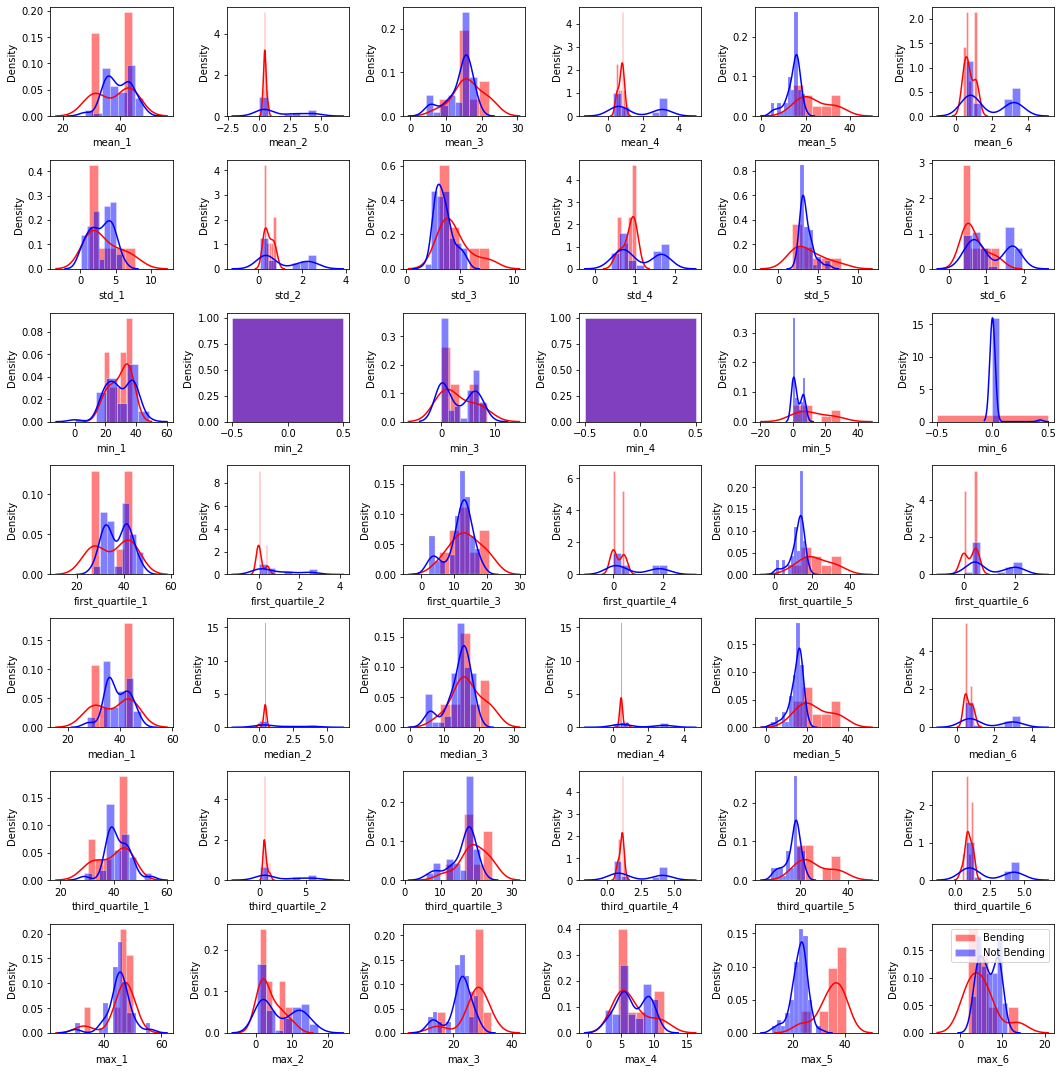

In [242]:
# https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
plt.figure(figsize=(15,15))
for i, ft in enumerate(features, start =1):
    for j in range(1,7):    
        plt.subplot(len(features), 6, 6*i+j-6)
        sns.histplot(bend_train.loc[bend_train['label']== 1][ft + str(j)] ,
                     kde = True,
                     color="red",
                     stat="density",
                     edgecolor=(1, 1, 1, .4),
                     kde_kws=dict(cut=3),
                     label="Bending")
        sns.histplot(bend_train.loc[bend_train['label']== 0][ft + str(j)], 
                     kde = True,
                     color="blue", 
                     stat="density",
                     kde_kws=dict(cut=3),
                     edgecolor=(1, 1, 1, .4),
                     label='Not Bending')
plt.tight_layout()
plt.legend()
plt.show()

I used plots to understand what features might be more useful. Based on the results:
- Mean , max and third Quartile would would be useful. 
- Mean would give the avg val of the series, 
- max would give the peak val of the series and 
- third quartile would give the higher bound val of series.

### __ISLR 3.7.4__
__I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 + β1X + β2X2 + β3X3 + ε__

__(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε . Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression.Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer__

Ans : The Cubic regression would be lower than the linear regression.

__(b) Answer (a) using test rather than training RSS.__

Ans : Linear Regression would be better.

__(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.__


Ans : Cubic regression would be better

__(d) Answer (c) using test rather than training RSS.__

Ans: There is not much information to tell.